<a href="https://colab.research.google.com/github/kurikinton105/GDL_code_colab/blob/main/06_03_qa_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 16kB/s 
     |████████████████████████████████| 450kB 33.5MB/s 
     |████████████████████████████████| 3.9MB 35.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=ab7a887f87f742286c1edcd29e53e9cce1de49147c5951940fb331bd6d31bd3e
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/My Drive/Colab Notebooks/GDL/

[Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/GDL/'
/content


In [ ]:
ls

sample_data/


In [ ]:
import importlib
import os

from keras.layers import Input, Embedding, GRU, GRUCell, Bidirectional, TimeDistributed, Dense, Lambda 
from keras.models import Model, load_model 
from keras.preprocessing.sequence import pad_sequences 
from keras.optimizers import Adam 
import keras.backend as K 
from keras.utils import plot_model

import numpy as np
import random

from utils.write import training_data, test_data, collapse_documents, expand_answers, _read_data, glove, START_TOKEN, END_TOKEN, look_up_token

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
# run params
SECTION = 'write'
RUN_ID = '0001'
DATA_NAME = 'qa'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

# data

In [ ]:
#### LOAD DATA ####

test_data_gen = test_data()
batch = next(test_data_gen)
batch = collapse_documents(batch)

# parameters

In [ ]:
VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMENS = glove.shape[1]

GRU_UNITS = 100
MAX_DOC_SIZE = None
MAX_ANSWER_SIZE = None
MAX_Q_SIZE = None

# architecture

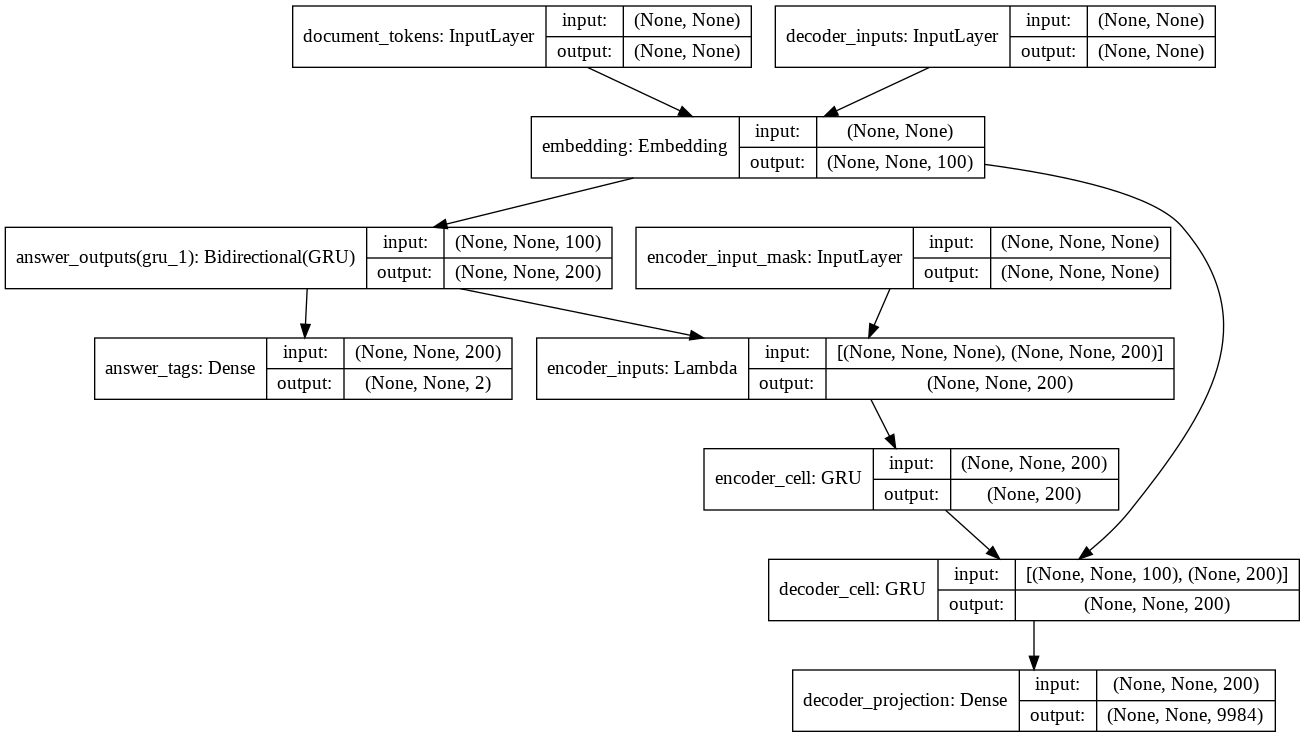

In [ ]:
#### TRAINING MODEL ####

document_tokens = Input(shape=(MAX_DOC_SIZE,), name="document_tokens")

embedding = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIMENS, weights=[glove], mask_zero = True, name = 'embedding')
document_emb = embedding(document_tokens)

answer_outputs = Bidirectional(GRU(GRU_UNITS, return_sequences=True), name = 'answer_outputs')(document_emb)
answer_tags = Dense(2, activation = 'softmax', name = 'answer_tags')(answer_outputs)

encoder_input_mask = Input(shape=(MAX_ANSWER_SIZE, MAX_DOC_SIZE), name="encoder_input_mask")
encoder_inputs = Lambda(lambda x: K.batch_dot(x[0], x[1]), name="encoder_inputs")([encoder_input_mask, answer_outputs])
encoder_cell = GRU(2 * GRU_UNITS, name = 'encoder_cell')(encoder_inputs)

decoder_inputs = Input(shape=(MAX_Q_SIZE,), name="decoder_inputs")
decoder_emb = embedding(decoder_inputs)
decoder_emb.trainable = False
decoder_cell = GRU(2 * GRU_UNITS, return_sequences = True, name = 'decoder_cell')
decoder_states = decoder_cell(decoder_emb, initial_state = [encoder_cell])

decoder_projection = Dense(VOCAB_SIZE, name = 'decoder_projection', activation = 'softmax', use_bias = False)
decoder_outputs = decoder_projection(decoder_states)

total_model = Model([document_tokens, decoder_inputs, encoder_input_mask], [answer_tags, decoder_outputs])
plot_model(total_model, to_file='model.png',show_shapes=True)

In [ ]:
#### INFERENCE MODEL ####

decoder_inputs_dynamic = Input(shape=(1,), name="decoder_inputs_dynamic")
decoder_emb_dynamic = embedding(decoder_inputs_dynamic)
decoder_init_state_dynamic = Input(shape=(2 * GRU_UNITS,), name = 'decoder_init_state_dynamic') #the embedding of the previous word
decoder_states_dynamic = decoder_cell(decoder_emb_dynamic, initial_state = [decoder_init_state_dynamic])
decoder_outputs_dynamic = decoder_projection(decoder_states_dynamic)

answer_model = Model(document_tokens, [answer_tags])
decoder_initial_state_model = Model([document_tokens, encoder_input_mask], [encoder_cell])
question_model = Model([decoder_inputs_dynamic, decoder_init_state_dynamic], [decoder_outputs_dynamic, decoder_states_dynamic])


In [ ]:
### LOAD MODEL WEIGHTS ####

model_num = 1

total_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)
question_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)
answer_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)
decoder_initial_state_model.load_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(model_num)), by_name = True)



ValueError: ignored

# testing

Predicted answer probabilities


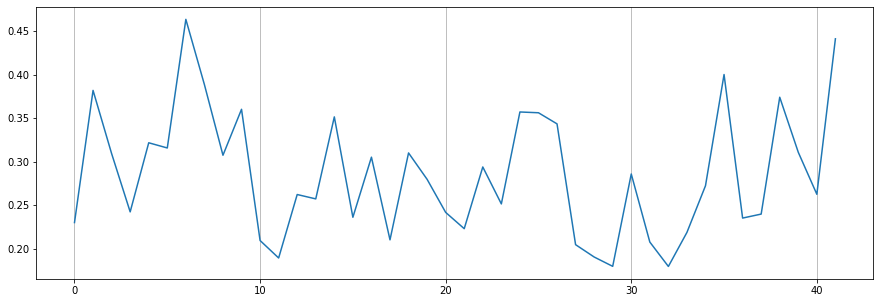

0 the 0.23
1 winning 0.38
2 goal 0.31
3 was 0.24
4 scored 0.32
5 by 0.32
6 23-year-old 0.46
7 striker 0.39
8 joe 0.31
9 bloggs 0.36
10 during 0.21
11 the 0.19
12 match 0.26
13 between 0.26
14 arsenal 0.35
15 and 0.24
16 barcelona 0.31
17 . 0.21
18 arsenal 0.31
19 recently 0.28
20 signed 0.24
21 the 0.22
22 striker 0.29
23 for 0.25
24 50 0.36
25 million 0.36
26 pounds 0.34
27 . 0.2
28 the 0.19
29 next 0.18
30 match 0.29
31 is 0.21
32 in 0.18
33 two 0.22
34 weeks 0.27
35 time, 0.4
36 on 0.24
37 july 0.24
38 31st 0.37
39 2005 0.31
40 . 0.26
41  0.44


In [ ]:
# answer placement predictions

plt.figure(figsize=(15,5))
idx = 0

answer_preds = answer_model.predict(batch["document_tokens"])

print('Predicted answer probabilities')
ax = plt.gca()
ax.xaxis.grid(True)
plt.plot(answer_preds[idx, :, 1])
plt.show()

for i in range(len(batch['document_words'][idx])):
    print(i, batch['document_words'][idx][i], np.round(answer_preds[idx][i][1],2))

In [ ]:
# set chosen answer position

start_answer = 37
end_answer = 39

print(batch['document_words'][idx][start_answer:(1+end_answer)])

['july', '31st', '2005']


In [ ]:

answer_preds = answer_model.predict(batch["document_tokens"])

answers = [[0] * len(answer_preds[idx])]
for i in range(start_answer, end_answer + 1):
    answers[0][i] = 1

answer_batch = expand_answers(batch, answers)

next_decoder_init_state = decoder_initial_state_model.predict([answer_batch['document_tokens'][[idx]], answer_batch['answer_masks'][[idx]]])

word_tokens = [START_TOKEN]
questions = [look_up_token(START_TOKEN)]

ended = False
counter = 0

while not ended:
    
    counter += 1

    word_preds, next_decoder_init_state = question_model.predict([word_tokens, next_decoder_init_state])

    next_decoder_init_state = np.squeeze(next_decoder_init_state, axis = 1)
    word_tokens = np.argmax(word_preds, 2)[0]

    questions.append(look_up_token(word_tokens[0]))

    if word_tokens[0] == END_TOKEN or counter > 20 :
        ended = True

questions = ' '.join(questions)



In [ ]:
questions

'<START> design surrounded dinner ceremonial quick jordan tickets venice tornadoes index aires cancellation begun development gatti 17th targets arias generations singing language'